In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from plotly import express
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import arrow
from umap import UMAP
import arrow
import warnings

2024-05-18 22:55:37.736712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 22:55:37.736871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 22:55:37.903693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
df = pd.read_csv(filepath_or_buffer=TRAIN, index_col=['Id'])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
TEST = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
test_df = pd.read_csv(filepath_or_buffer=TEST)

In [4]:
# Dealing with NaNs

TARGET = 'SalePrice'
keys = [key for key, value in df.drop(columns=[TARGET]).dtypes.to_dict().items() if str(value) in {'int64', 'float64'}]
numerical_columns = [key for key in keys if test_df[key].isna().sum() == 0]
# print(keys)
# print(numerical_columns)
print(df[numerical_columns].isna().sum())

MSSubClass       0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64


In [5]:
time_start = arrow.now()
reducer = UMAP(
    n_components=2,
    random_state=2024,
    transform_seed=2024,
    verbose=True,
    n_jobs=1,
    n_epochs=1000
)
umap_df = pd.DataFrame(
    data=reducer.fit_transform(X=df[numerical_columns]),
    columns=['x', 'y']
)
umap_df[TARGET] = df[TARGET].tolist()
express.scatter(
    data_frame=umap_df,
    x='x',
    y='y',
    color=TARGET,
).show()
print('UMAP done in {}'.format(arrow.now() - time_start))

UMAP(n_epochs=1000, n_jobs=1, random_state=2024, transform_seed=2024, verbose=True)
Sat May 18 22:55:50 2024 Construct fuzzy simplicial set
Sat May 18 22:55:52 2024 Finding Nearest Neighbors
Sat May 18 22:55:57 2024 Finished Nearest Neighbor Search
Sat May 18 22:56:00 2024 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat May 18 22:56:08 2024 Finished embedding


UMAP done in 0:00:20.048386


In [6]:
warnings.filterwarnings(action='ignore', category=FutureWarning)
train_plot_df = umap_df.drop(columns=[TARGET])
train_plot_df['data'] = 'train'
test_plot_df = pd.DataFrame(
    data=reducer.transform(X=test_df[numerical_columns]),
    columns=['x', 'y']
)
test_plot_df['data'] = 'test'
plot_df = pd.concat(objs=[train_plot_df, test_plot_df])
express.scatter(
    data_frame=plot_df,
    x='x',
    y='y',
    color='data'
).show()

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[numerical_columns], df[TARGET], test_size=0.20, random_state=20)
Model = Ridge(tol=1e-4, solver='lbfgs', random_state=2024, max_iter=10000, positive=True)
Model.fit(X_train, y_train)
print('rmse: {:5.4f}'.format(mean_squared_error(y_true=np.log(y_test), y_pred=np.log(Model.predict(X_test)), squared=False)))

rmse: 0.1858


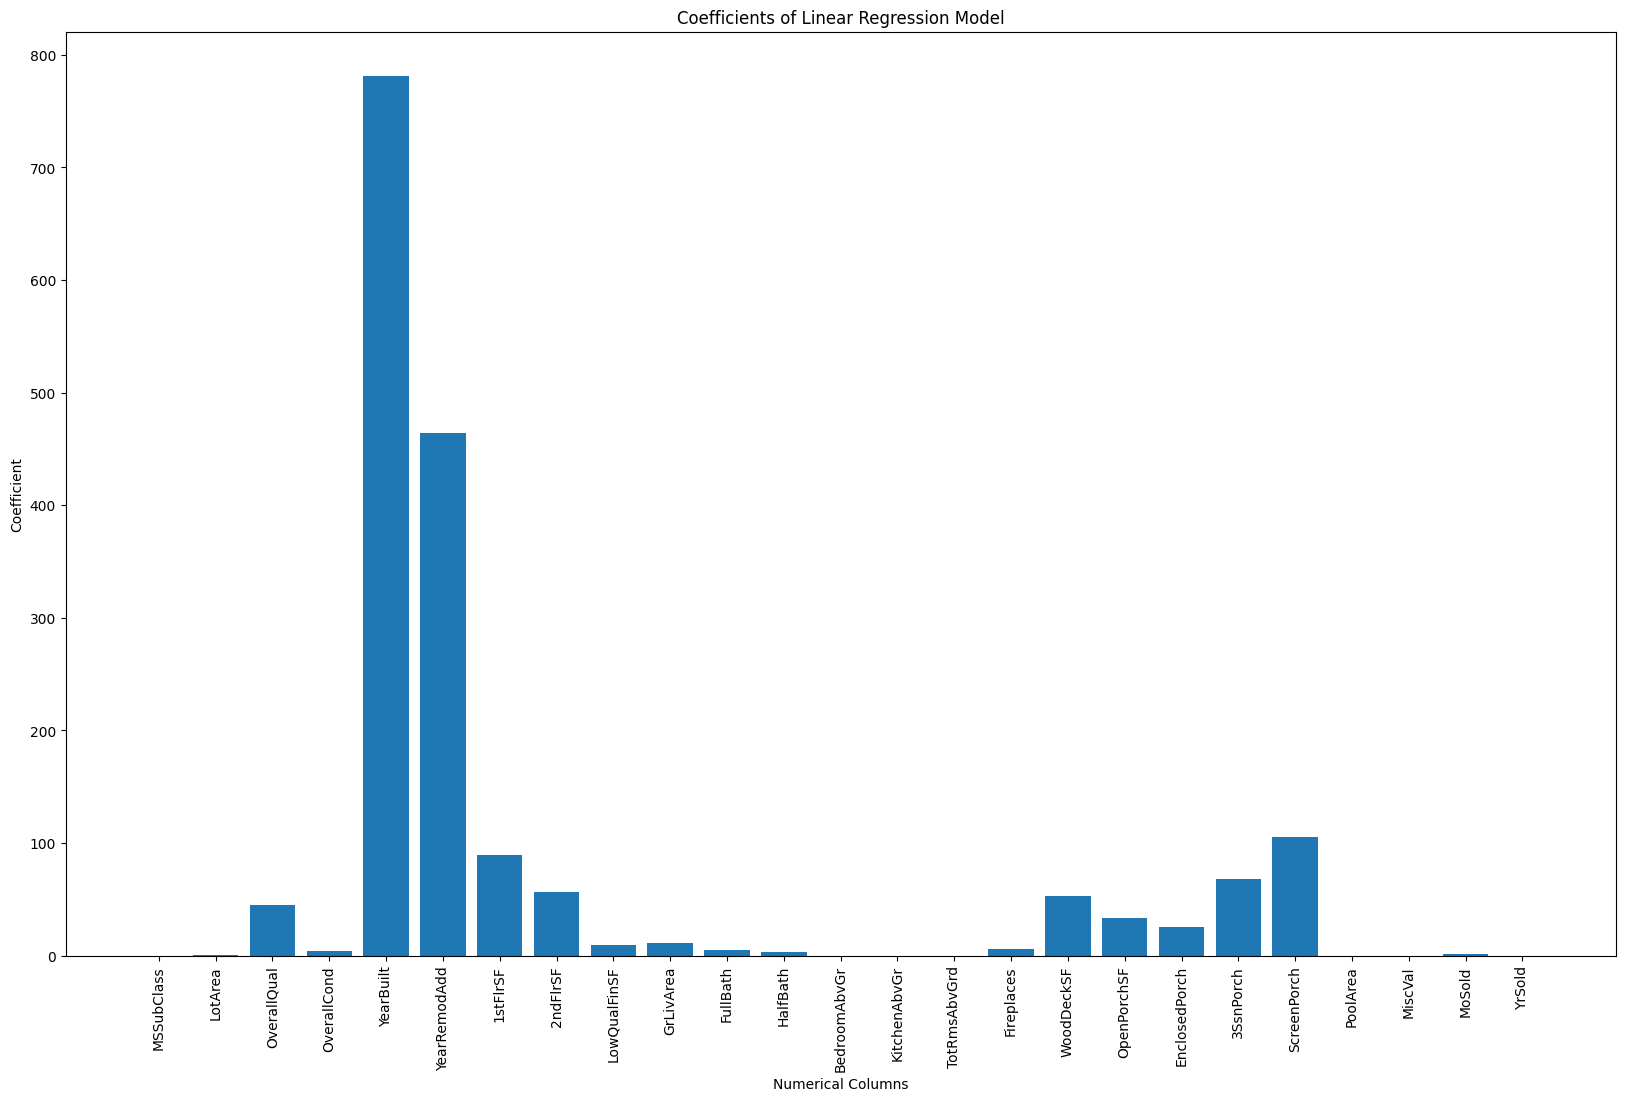

In [8]:
plt.figure(figsize=(20, 12))
plt.bar(numerical_columns, Model.coef_)
plt.xlabel('Numerical Columns')
plt.ylabel('Coefficient')
plt.title('Coefficients of Linear Regression Model')
plt.xticks(rotation=90)
plt.show()


In [9]:
scores = []
name = "Ridge"
for random_state in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(df[numerical_columns], df[TARGET], test_size=0.20, random_state=random_state)
    Model.fit(X=X_train, y=y_train)
    y_pred = Model.predict(X=X_test)
    score = mean_squared_error(y_true=np.log(y_test), y_pred=np.log(Model.predict(X_test)), squared=False)
    scores.append(score)

title = 'score: {:5.4f} model: {}'.format(sum(scores)/len(scores), name)
scores_df = pd.DataFrame(data=scores, columns=['score'])
scores_df['mean'] = scores_df['score'].expanding().mean()

express.line(
    data_frame=scores_df,
    y=['score', 'mean'],
    title=title
).show()

In [10]:
SUBMISSION = '/kaggle/working/submission.csv'

y_tree_pred = Model.fit(X=df[numerical_columns], y=df[TARGET]).predict(X=test_df[numerical_columns])
pd.DataFrame(data={'Id': test_df['Id'], 'SalePrice': y_tree_pred}).to_csv(path_or_buf=SUBMISSION, index=False)
print("Submissuion file has been created sucessfully")

Submissuion file has been created sucessfully
